In [1]:
# data processing
import numpy as np
import os
import sys
import pandas as pd
import pickle

# Machine learning library
import h2o
from h2o.automl import H2OAutoML
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, roc_curve, auc

# data visualizations
import matplotlib.pyplot as plt
import seaborn as sns

from svm_utils import *
from data_configuration import *


In [2]:
# Get unprocessed data
dataset = getCSVData(Location.creditcard_data_raw)
dataset.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


<Axes: >

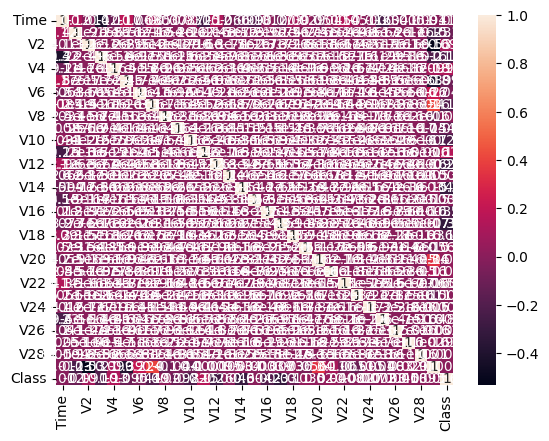

In [15]:
sns.heatmap(dataset.corr(), annot=True)

In [3]:
# get the data
X_train, X_test, Y_train, Y_test = getProcessedData(Location.creditcard_data_process)
Y_train.values.reshape(-1, 1)


array([[0],
       [1],
       [0],
       ...,
       [0],
       [1],
       [1]], dtype=int64)

In [4]:
# Standardize features. Require for Machine learning
sc = StandardScaler()
# Fit to data, then transform it
X_train = sc.fit_transform(X_train)


In [5]:
# Perform standardization by centering and scaling
X_test = sc.transform(X_test)

In [6]:
# Init an H2O cluster
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,17 mins 05 secs
H2O_cluster_timezone:,Asia/Jerusalem
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.1
H2O_cluster_version_age:,19 days
H2O_cluster_name:,H2O_from_python_Administrator_m08n9k
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.405 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [7]:
# Convert training data to H2OFrame
# the train result will be used to train a machine learning model
train = h2o.H2OFrame(np.concatenate((X_train, Y_train.values.reshape(-1, 1)), axis=1))
train.columns = list(dataset.columns)
train[ProcessConfig.creditcard_label] = train[ProcessConfig.creditcard_label].asfactor()

# Specify target variable and predictor variables
x = train.columns[:-1]
y = train.columns[-1]


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [8]:
# Run H2O AutoML to automatically select, train and optimize SVM model
aml = H2OAutoML(max_models=10, sort_metric='mse', max_runtime_secs=5 * 60, seed=666)
aml.train(x=x, y=y, training_frame=train)

AutoML progress: |█
19:31:55.344: AutoML: XGBoost is not available; skipping it.

██████████████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_1_AutoML_2_20230227_193154


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    140                140                         701641                 15           15           15            163           616           393.886

ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 4.7140899079314206e-07
RMSE: 0.0006865923031851887
LogLoss: 5.13129229104017e-05
Mean Per-Class Error: 0.0
AUC: 1.0
AUCPR: 1.0
Gini: 1.0

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.9292700035963766
       0       1       Error    Rate
-----  ------  ------  -------  --------------
0      159349  0       0        (0.0/159349.0)
1      0       159236  0        (0.0/159236.0)
Total  159349  159236  0        (0.0/318585.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.92927      1         170
max f2                       0.92927      1         170
max f0point5                 0.92927      1         170
max accuracy                 0.92927      1         170
max precision                0.999998     1         0
max recall                   0.92927      1         170
max specificity              0.999998     1         0
max absolute_mcc             0.92927      1         170
max min_per_class_accuracy   0.92927      1         170
max mean_per_class_accuracy  0.92927      1         170
max tns                      0.999998     159349    0
max fns                      0.999998     84264     0
max fps                      2.33623e-06  159349    399
max tps                      0.92927      159236    170
max tnr                      0.999998     1         0
max fnr                      0.999998     0.529177  0
max fpr                      2.33623e-06  1         399
max tpr                      0.92927      1         170

Gains/Lift Table: Avg response rate: 49.98 %, avg score: 49.98 %
group    cumulative_data_fraction    lower_threshold    lift     cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain     cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  -------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  -------  -----------------  --------------------
1        0.0100099                   0.999999           2.00071  2.00071            1                0.999999     1                           0.999999            0.0200269       0.0200269                  100.071  100.071            0.0200269
2        0.0206789                   0.999999           2.00071  2.00071            1                0.999999     1                           0.999999            0.0213457       0.0413726                  100.071  100.071            0.0413726
3        0.0300234                   0.999999           2.00071  2.00071            1                0.999999     1                           0.999999            0.0186955       0.0600681                  100.071  100.071            0.0600681
4        0.0400019                   0.999998           2.00071  2.00071            1                0.999998     1                           0.999999            0.0199641       0.0800322                  100.071  100.071            0.0800322
5        0.0503351                   0.999998           2.00071  2.00071            1                0.999998     1                           0.999999            0.0206737       

In [9]:
# View the leaderboard of trained models
lb = aml.leaderboard
print(lb.head())

model_id                                mse       auc     logloss     aucpr    mean_per_class_error       rmse
GBM_1_AutoML_2_20230227_193154  0.00019531   0.999962  0.0016583   0.999952             0.000175108  0.0139753
GBM_2_AutoML_2_20230227_193154  0.000408117  0.99985   0.00411516  0.999759             0.000240855  0.0202019
DRF_1_AutoML_2_20230227_193154  0.000435736  0.999949  0.00443254  0.999905             0.000218885  0.0208743
GLM_1_AutoML_2_20230227_193154  0.0196089    0.996411  0.0760274   0.996701             0.0236105    0.140032
[4 rows x 7 columns]



In [10]:
# Use the best model to predict on test data
model = aml.leader
X_h2o = h2o.H2OFrame(X_test)
X_h2o.columns = list(dataset.columns)[:-1]
y_pred = model.predict(X_h2o).as_data_frame().values.flatten()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


In [11]:
# Train a PySVM SVM model
model = LinearSVC(random_state=0, tol=1e-5, max_iter=10000, dual=False)
Y_pred = model.fit(X_train, Y_train)

In [12]:
# Test the model on the test data
y_pred = model.predict(X_test)
misclassified = np.where(Y_test != y_pred)[0]
print("Indices of potentially misclassified instances: ", misclassified)

Indices of potentially misclassified instances:  [    56     90    113 ... 113657 113694 113723]


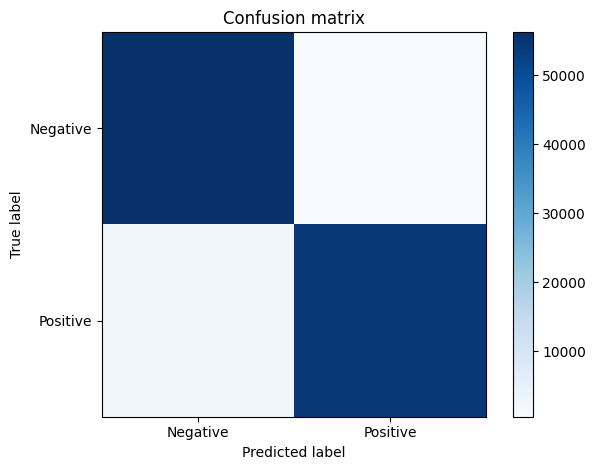

In [13]:
# Confusion matrix - summarizing the performance of a classification algorithm.
cm = confusion_matrix(Y_test, y_pred)
plt.figure()
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title("Confusion matrix")
plt.colorbar()
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.xticks([0, 1], ["Negative", "Positive"])
plt.yticks([0, 1], ["Negative", "Positive"])
plt.tight_layout()
plt.show()

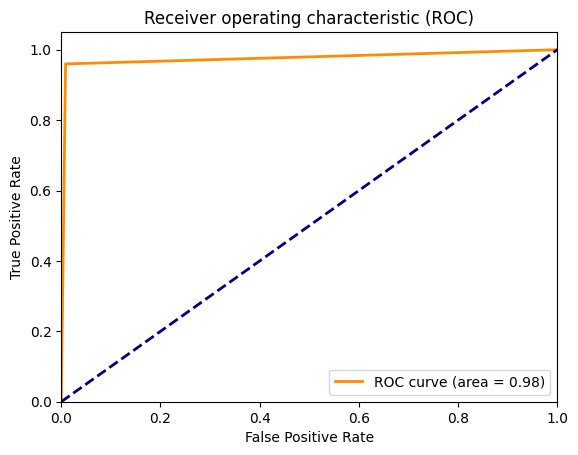

In [14]:
# ROC curve
fpr, tpr, thresholds = roc_curve(Y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic (ROC)")
plt.legend(loc="lower right")
plt.show()